In [142]:
import pandas as pd
import numpy as np
import re

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline

from joblib import dump
from joblib import load

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import  recall_score

from sklearn.metrics import classification_report
import sklearn.metrics as metrics

from imblearn.combine import SMOTETomek,SMOTEENN
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours

In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
data = pd.read_csv("/content/drive/My Drive/Outbound/mbti_1.csv",encoding='utf-8')

In [125]:
data.type.head()

0    INFJ
1    ENTP
2    INTP
3    INTJ
4    ENTJ
Name: type, dtype: object

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


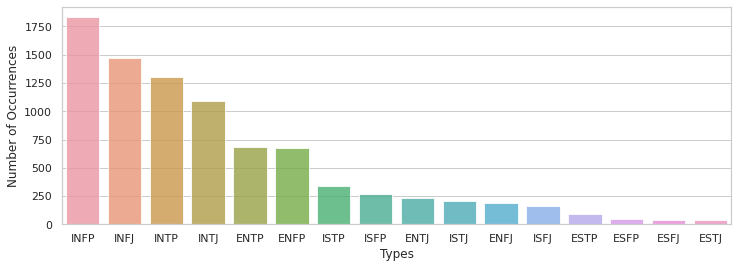

In [126]:
cnt_types = data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_types.index, cnt_types.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [127]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    F = 0; P = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E incorrect')
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S incorrect')
        
    if t[2] == 'F': F = 1
    elif t[2] == 'T': F = 0
    else: print('T-F incorrect')
        
    if t[3] == 'P': P = 1
    elif t[3] == 'J': P = 0
    else: print('J-P incorrect')
    return pd.Series( {'IE':I, 'NS':N , 'FT': F, 'PJ': P }) 

data = data.join(data.apply (lambda row: get_types (row),axis=1))
data.head(5)

,type,posts,IE,NS,FT,PJ
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,1,0
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,0,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,0,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,0,0
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,0,0


In [128]:
print ("Introversion (I) /  Extroversion (E):\t", data['IE'].value_counts()[0], " / ", data['IE'].value_counts()[1])
print ("Intuition (N) – Sensing (S):\t\t", data['NS'].value_counts()[0], " / ", data['NS'].value_counts()[1])
print ("Feeling (F) - Thinking (T):\t\t", data['FT'].value_counts()[0], " / ", data['FT'].value_counts()[1])
print ("Perceiving (P) - Judging (J):\t\t", data['PJ'].value_counts()[0], " / ", data['PJ'].value_counts()[1])

Introversion (I) /  Extroversion (E):	 1999  /  6676
Intuition (N) – Sensing (S):		 1197  /  7478
Feeling (F) - Thinking (T):		 3981  /  4694
Perceiving (P) - Judging (J):		 3434  /  5241


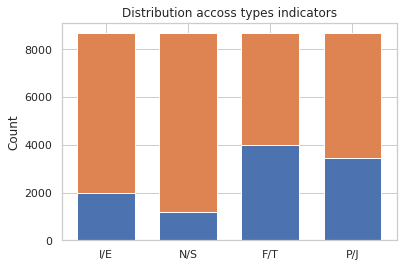

In [129]:
N = 4
but = (data['IE'].value_counts()[0], data['NS'].value_counts()[0], data['FT'].value_counts()[0], data['PJ'].value_counts()[0])
top = (data['IE'].value_counts()[1], data['NS'].value_counts()[1], data['FT'].value_counts()[1], data['PJ'].value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
width = 0.7      # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, but, width)
p2 = plt.bar(ind, top, width, bottom=but)

plt.ylabel('Count')
plt.title('Distribution accoss types indicators')
plt.xticks(ind, ('I/E',  'N/S', 'F/T', 'P/J',))

plt.show()

In [130]:
data[['IE','NS','FT','PJ']].corr()

,IE,NS,FT,PJ
IE,1.000000,-0.045899,0.069573,-0.161939
NS,-0.045899,1.000000,0.080954,-0.014922
FT,0.069573,0.080954,1.000000,-0.004673
PJ,-0.161939,-0.014922,-0.004673,1.000000


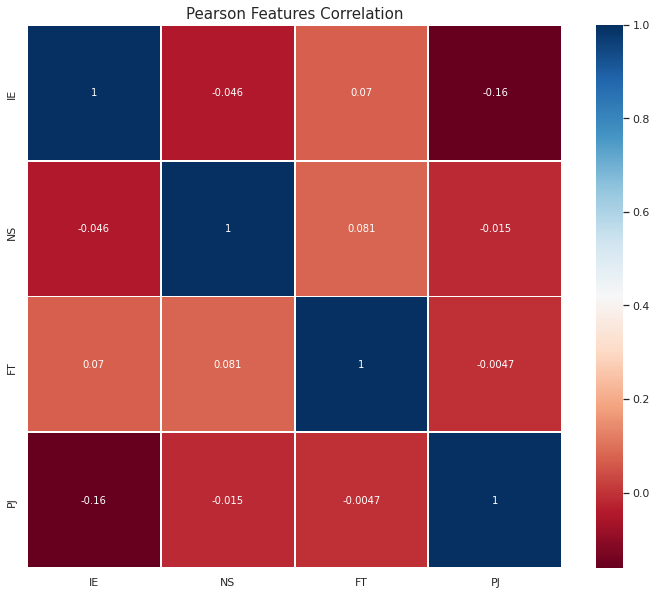

In [131]:
cmap = plt.cm.RdBu
corr = data[['IE','NS','FT','PJ']].corr()
plt.figure(figsize=(12,10))
plt.title('Pearson Features Correlation', size=15)
sns.heatmap(corr, cmap=cmap,  annot=True, linewidths=1)

In [132]:
b_Pers = {'I':1, 'E':0, 'N':1, 'S':0, 'F':1,'T':0,   'P':1,'J':0,}
b_Pers_list = [{1:'I', 0:'E'}, {1:'N', 0:'S'}, {1:'F', 0:'T'}, {1:'P', 0:'J' }]

def translate_personality(personality):
    # transform mbti to binary vector
    
    return [b_Pers[l] for l in personality]

def translate_back(personality):
    # transform binary vector to mbti personality
    
    s = ""
    t = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
        if b_Pers_list[i][l] == 'I':
          t += 'Introversion,'
        elif b_Pers_list[i][l] == 'N':
          t += ' Intuition,'
        elif b_Pers_list[i][l] == 'F':
          t += ' Feeling,'
        elif b_Pers_list[i][l] == 'P':
          t += ' Perceiving'
        elif b_Pers_list[i][l] == 'E':
          t += ' Extroversion,'
        elif b_Pers_list[i][l] == 'S':
          t += ' Sensing,'
        elif b_Pers_list[i][l] == 'T':
          t += ' Thinking,'
        else:
          t += ' Judging'
    
    t = 'Person possesses following personality :- ' + t
            
    return s,t

# Check ...
d = data.head(4)
list_personality_bin = np.array([translate_personality(p) for p in d.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)


Binarize MBTI list: 
[[1 1 1 0]
 [0 1 0 1]
 [1 1 0 1]
 [1 1 0 0]]


In [133]:
import nltk
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk import word_tokenize


nltk.download('stopwords')
nltk.download('wordnet')

# We want to remove these from the psosts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
  
unique_type_list = [x.lower() for x in unique_type_list]


# Lemmatize
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

# Cache the stop words for speed 
cachedStopWords = stopwords.words("english")

def pre_process_data(data, remove_stop_words=True, remove_mbti_profiles=True,Type = True):

    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if (i % 500 == 0 or i == 1 or i == len_data):
            print("%s of %s rows" % (i, len_data))

        ##### Remove and clean comments
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
            
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t,"")
        
        if Type:

          type_labelized = translate_personality(row[1].type)
          list_personality.append(type_labelized)
        
        list_posts.append(temp)

    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [134]:
list_posts, list_personality  = pre_process_data(data, remove_stop_words=True,Type = True)

1 of 8675 rows
500 of 8675 rows
1000 of 8675 rows
1500 of 8675 rows
2000 of 8675 rows
2500 of 8675 rows
3000 of 8675 rows
3500 of 8675 rows
4000 of 8675 rows
4500 of 8675 rows
5000 of 8675 rows
5500 of 8675 rows
6000 of 8675 rows
6500 of 8675 rows
7000 of 8675 rows
7500 of 8675 rows
8000 of 8675 rows
8500 of 8675 rows
8675 of 8675 rows


In [135]:
print("Num posts and personalities: ",  list_posts.shape, list_personality.shape)

Num posts and personalities:  (8675,) (8675, 4)


In [136]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

# Posts to a matrix of token counts
cntizer = CountVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,  
                             max_df=0.7,
                             min_df=0.1) 

# Learn the vocabulary dictionary and return term-document matrix
print("CountVectorizer...")
X_cnt = cntizer.fit_transform(list_posts)

# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

print("Tf-idf...")
# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()

CountVectorizer...
Tf-idf...


In [137]:
feature_names = list(enumerate(cntizer.get_feature_names()))
feature_names

[(0, 'ability'),
 (1, 'able'),
 (2, 'absolutely'),
 (3, 'accept'),
 (4, 'accurate'),
 (5, 'across'),
 (6, 'act'),
 (7, 'action'),
 (8, 'actual'),
 (9, 'actually'),
 (10, 'add'),
 (11, 'admit'),
 (12, 'advice'),
 (13, 'afraid'),
 (14, 'age'),
 (15, 'ago'),
 (16, 'agree'),
 (17, 'ah'),
 (18, 'almost'),
 (19, 'alone'),
 (20, 'along'),
 (21, 'already'),
 (22, 'although'),
 (23, 'amazing'),
 (24, 'amount'),
 (25, 'angry'),
 (26, 'animal'),
 (27, 'annoying'),
 (28, 'another'),
 (29, 'answer'),
 (30, 'anxiety'),
 (31, 'anymore'),
 (32, 'anyone'),
 (33, 'anything'),
 (34, 'anyway'),
 (35, 'apparently'),
 (36, 'appreciate'),
 (37, 'approach'),
 (38, 'area'),
 (39, 'argument'),
 (40, 'around'),
 (41, 'art'),
 (42, 'ask'),
 (43, 'asked'),
 (44, 'asking'),
 (45, 'aspect'),
 (46, 'assume'),
 (47, 'attention'),
 (48, 'attracted'),
 (49, 'avatar'),
 (50, 'avoid'),
 (51, 'aware'),
 (52, 'away'),
 (53, 'awesome'),
 (54, 'awkward'),
 (55, 'baby'),
 (56, 'back'),
 (57, 'bad'),
 (58, 'based'),
 (59, 'basi

In [138]:
X_tfidf.shape

(8675, 791)

In [139]:
type_indicators = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) – Sensing (S)", 
                   "FT: Feeling (F) - Thinking (T)", "PJ: Perceiving (P) - Judging (J)"  ]

for l in range(len(type_indicators)):
    print(type_indicators[l])

IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) – Sensing (S)
FT: Feeling (F) - Thinking (T)
PJ: Perceiving (P) - Judging (J)


In [140]:
list_personality[0,:]

array([1, 1, 1, 0])

In [141]:
print("MBTI 1st row: %s and it's description is %s" % translate_back(list_personality[0,:]))
print("Y: Binarized MBTI 1st row: %s" % list_personality[0,:])

MBTI 1st row: INFJ and it's description is Person possesses following personality :- Introversion, Intuition, Feeling, Judging
Y: Binarized MBTI 1st row: [1 1 1 0]


In [109]:
# # First XGBoost model for MBTI dataset
# from numpy import loadtxt
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Posts in tf-idf representation
# X = X_tfidf

# # Let's train type indicator individually
# for l in range(len(type_indicators)):
#     print("%s ..." % (type_indicators[l]))
    
#     # Let's train type indicator individually
#     Y = list_personality[:,l]

#     # split data into train and test sets
#     seed = 7
#     test_size = 0.33
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
    
#     # fit model on training data
#     model = XGBClassifier()
#     model.fit(X_train, y_train)

#     # make predictions for test data
#     y_pred = model.predict(X_test)
#     predictions = [round(value) for value in y_pred]
#     # evaluate predictions
#     accuracy = accuracy_score(y_test, predictions)
#     print("* %s Accuracy: %.2f%%" % (type_indicators[l], accuracy * 100.0))

NS: Intuition (N) – Sensing (S) ...


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


* NS: Intuition (N) – Sensing (S) Accuracy: 86.51%
Saved model to: /content/drive/My Drive/Outbound/mbtiNS.joblib.dat
Accuracy (overall correct predictions): 0.87
Auc: 0.72
              precision    recall  f1-score   support

           0       0.71      0.02      0.04       237
           1       0.87      1.00      0.93      1498

    accuracy                           0.87      1735
   macro avg       0.79      0.51      0.48      1735
weighted avg       0.85      0.87      0.81      1735

Recall (all 1s predicted right): 1.0
Precision (confidence when predicting a 1): 0.87
F1 score: 0.93


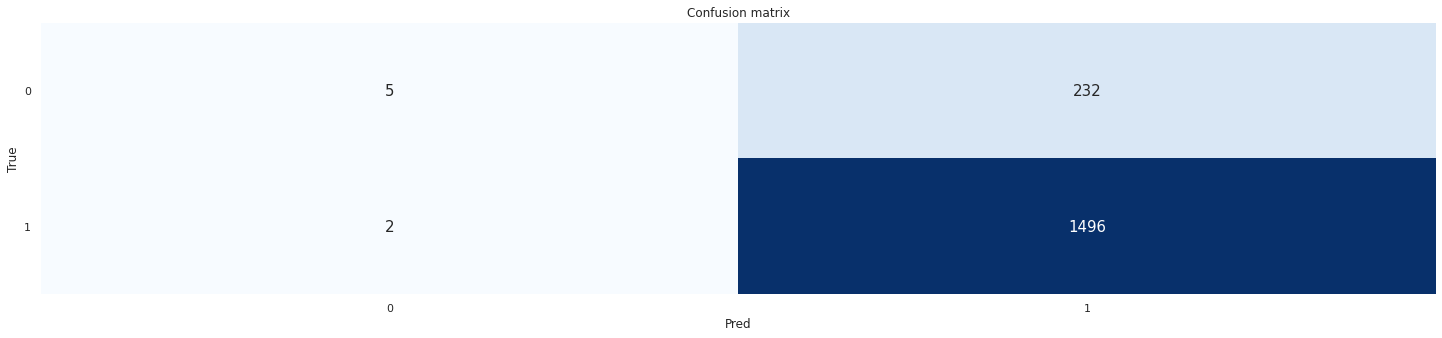

In [112]:
#resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

# Posts in tf-idf representation
X = X_tfidf

# Let's train type indicator individually
# for l in range(len(type_indicators)):
for l in range(1,2):
    print("%s ..." % (type_indicators[l]))
    
    # Let's train type indicator individually
    Y = list_personality[:,l]

    # split data into train and test sets
    seed = 7
    test_size = 0.20
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    X_smt, y_smt = resample.fit_sample(X_train,y_train)
    
    # fit model on training data
    model = SVC(probability=True)
    model.fit(X_smt, y_smt)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("* %s Accuracy: %.2f%%" % (type_indicators[l], accuracy * 100.0))

    model_name = '/content/drive/My Drive/Outbound/mbti'+type_indicators[l][0:2]+'.joblib.dat'
    dump(model, model_name)
    print("Saved model to:",model_name)
    predicted_prob = model.predict_proba(X_test)[:,1]
    accuracy = metrics.accuracy_score(y_test, predictions)
    auc = metrics.roc_auc_score(y_test, predicted_prob)
    print("Accuracy (overall correct predictions):",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print(metrics.classification_report(y_test, predictions))

    ## Precision e Recall
    recall = metrics.recall_score(y_test, predictions)  #= true 1s / all 1s in test (got and missed)
    precision = metrics.precision_score(y_test, predictions)  #= true 1s / all 1s predicted (true 1s + false 1s)
    f1 = metrics.f1_score(y_test, predictions)  #=2 * (precision * recall) / (precision + recall)
    print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
    print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
    print("F1 score:", round(f1,2))
    
    ## Plot confusion matrix
    classes = np.unique(y_test)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,5))
    cm = metrics.confusion_matrix(y_test, predictions, labels=classes)
    sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
    ax.set_yticklabels(labels=classes, rotation=0)

In [113]:
np.unique(predictions)

array([0, 1])

In [120]:
y_pred_1 = model.predict(X_smt)

In [121]:
 accuracy = metrics.accuracy_score(y_smt,y_pred_1)
 accuracy

0.9900501672240802

In [88]:
    recall = metrics.recall_score(y_smt,y_pred_1)  #= true 1s / all 1s in test (got and missed)
    precision = metrics.precision_score(y_smt,y_pred_1)  #= true 1s / all 1s predicted (true 1s + false 1s)
    f1 = metrics.f1_score(y_smt,y_pred_1)  #=2 * (precision * recall) / (precision + recall)
    print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
    print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
    print("F1 score:", round(f1,2))

Recall (all 1s predicted right): 1.0
Precision (confidence when predicting a 1): 0.97
F1 score: 0.98


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

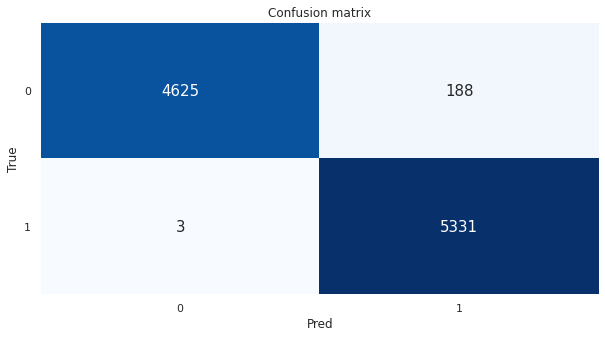

In [87]:
classes = np.unique(y_smt)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
cm = metrics.confusion_matrix(y_smt, y_pred_1, labels=classes)
sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)

In [117]:
X_smt.shape, y_smt.shape, X_train.shape,y_train.shape,X_test.shape,y_test.shape

((11960, 791), (11960,), (6940, 791), (6940,), (1735, 791), (1735,))

In [119]:
dataframe=pd.DataFrame(y_smt, columns=['a']) 
dataframe.value_counts()

a
1    5980
0    5980
dtype: int64

In [118]:
dataframe=pd.DataFrame(y_test, columns=['a']) 
dataframe.value_counts()

a
1    1498
0     237
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Target Variable Frequency')

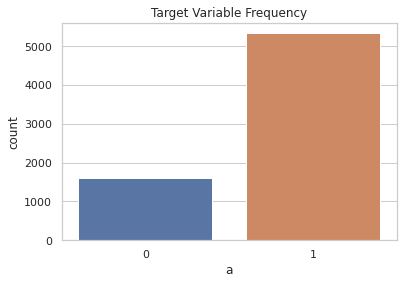

In [79]:
import seaborn as sns
sns.countplot(dataframe['a']);
sns.set(style="whitegrid")
plt.title('Target Variable Frequency')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Target Variable Frequency')

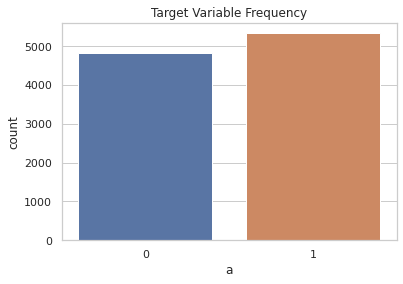

In [76]:
import seaborn as sns
sns.countplot(dataframe['a']);
sns.set(style="whitegrid")
plt.title('Target Variable Frequency')

In [ ]:
predictions.count(1)

In [ ]:
X_train.shape, _test.shape

In [ ]:
from sklearn.metrics import roc_auc_score
predicted_prob = model.predict_proba(X_test)[:,1]
accuracy = metrics.accuracy_score(y_test, predictions)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))

In [103]:
predictions.count(0)

28

In [104]:
predictions.count(1)

1707

In [96]:
a = pd.DataFrame(data=y_test,columns=['ajit'])

In [100]:
a['ajit'].value_counts()

1    1342
0     393
Name: ajit, dtype: int64

In [49]:
type_indicators[0][0:2]

'IE'

IE: Introversion (I) / Extroversion (E) ...
inside
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 57.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


* Best: 0.773775 using {'clf': SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False), 'clf__C': 1, 'clf__gamma': 1, 'smtenn': SMOTEENN(enn=EditedNearestNeighbours(kind_sel='all', n_jobs=1, n_neighbors=3,
                                     random_state=None, ratio=None,
                                     return_indices=False,
                                     sampling_strategy='majority'),
         random_state=None, ratio=None, sampling_strategy='auto', smote=None)}
Saved model to: /content/drive/My Drive/Outbound/mbti_kfoldIE.joblib.dat
Accuracy (overall correct predictions): 0.78
              precision    recall  f1-score   support

           0       0.58      0.07      0.13       393
           1       0.78      0.99      0.87      1342

    accuracy                           0.78      173

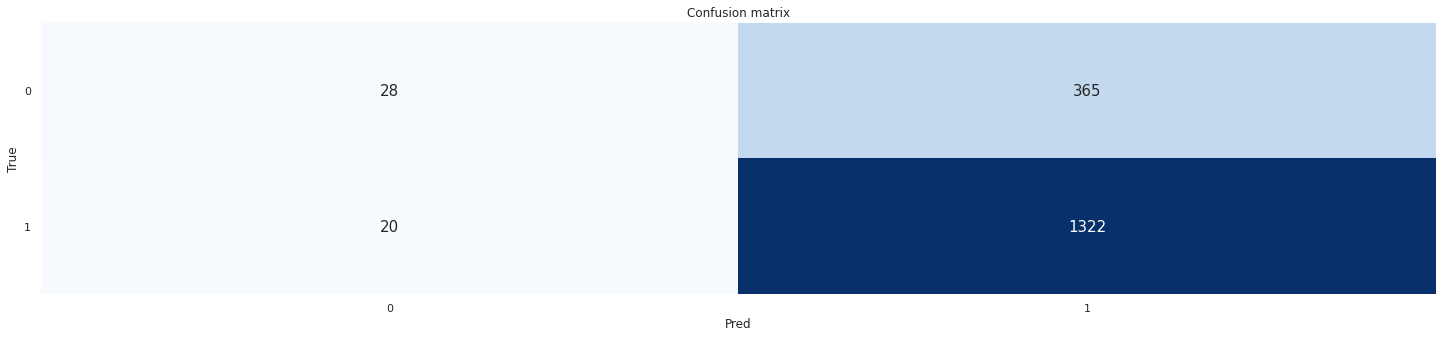

In [143]:
# Posts in tf-idf representation
X = X_tfidf

# Let's train type indicator individually
#for l in range(len(type_indicators)):
for l in range(0,1):
    print("%s ..." % (type_indicators[l]))

    Y = list_personality[:,l]
    model = SVC()
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    C = [0.1,1, 10, 100]
    gamma = [1,0.1,0.01,0.001]

    seed = 7
    test_size = 0.20
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    if type_indicators[l][0:2] == 'IE' or type_indicators[l][0:2] == 'NS':
      
      print('inside')
      pipe_nn_ENN = Pipeline([
          ('smtenn', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),
          ('clf',model)])
    
      pipe_grid_ENN = [
             {'smtenn': [SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))],
             'clf':[model],
             'clf__C' :  C,
             'clf__gamma' : gamma        
      }]
          
      grid_search = GridSearchCV(pipe_nn_ENN, pipe_grid_ENN, scoring="accuracy",verbose=3, n_jobs=-1, cv=kfold).fit(X_train, y_train)

    else:
      param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]}
      grid_search = GridSearchCV(model, param_grid, scoring="accuracy",verbose=3, n_jobs=-1, cv=kfold).fit(X_train, y_train)

    # summarize results
    print("* Best: %f using %s" % (grid_search.best_score_,grid_search.best_params_))
    model_name = '/content/drive/My Drive/Outbound/mbti_kfold'+type_indicators[l][0:2]+'.joblib.dat'
    dump(grid_search, model_name)
    print("Saved model to:",model_name)
    predicted = grid_search.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, predicted)
    print("Accuracy (overall correct predictions):",  round(accuracy,2))
    print(metrics.classification_report(y_test, predicted))

    ## Precision e Recall
    recall = metrics.recall_score(y_test, predicted)  #= true 1s / all 1s in test (got and missed)
    precision = metrics.precision_score(y_test, predicted)  #= true 1s / all 1s predicted (true 1s + false 1s)
    f1 = metrics.f1_score(y_test, predicted)  #=2 * (precision * recall) / (precision + recall)
    print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
    print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
    print("F1 score:", round(f1,2))
    
    ## Plot confusion matrix
    classes = np.unique(y_test)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
    sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
    ax.set_yticklabels(labels=classes, rotation=0)

IE: Introversion (I) / Extroversion (E) ...
inside
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 88.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


* Best: 0.777233 using {'clf': SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False), 'clf__C': 1, 'clf__gamma': 1, 'smttmk': SMOTETomek(random_state=None, ratio=None, sampling_strategy='auto', smote=None,
           tomek=TomekLinks(n_jobs=1, random_state=None, ratio=None,
                            return_indices=False,
                            sampling_strategy='majority'))}
Saved model to: /content/drive/My Drive/Outbound/mbti_kfoldIE.joblib.dat
Accuracy (overall correct predictions): 0.78
              precision    recall  f1-score   support

           0       0.59      0.16      0.25       393
           1       0.80      0.97      0.87      1342

    accuracy                           0.78      1735
   macro avg       0.69      0.56      0.56      1735
weighted avg       0.75      0.78    

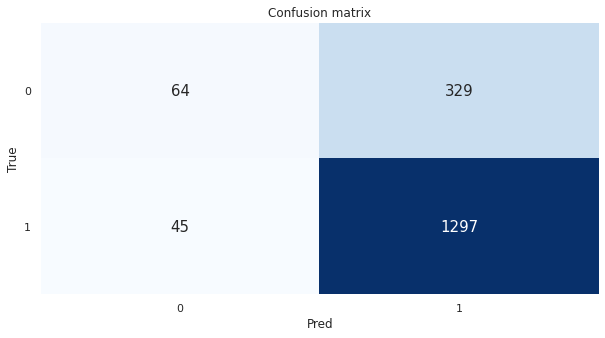

In [145]:
# Posts in tf-idf representation
X = X_tfidf

# Let's train type indicator individually
#for l in range(len(type_indicators)):
for l in range(0,1):
    print("%s ..." % (type_indicators[l]))

    Y = list_personality[:,l]
    model = SVC()
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    C = [0.1,1, 10, 100]
    gamma = [1,0.1,0.01,0.001]

    seed = 7
    test_size = 0.20
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    if type_indicators[l][0:2] == 'IE' or type_indicators[l][0:2] == 'NS':
      
      print('inside')
      pipe_nn_ENN = Pipeline([
          ('smttmk', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
          ('clf',model)])
    
      pipe_grid_ENN = [
             {'smttmk': [SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))],
             'clf':[model],
             'clf__C' :  C,
             'clf__gamma' : gamma        
      }]
          
      grid_search = GridSearchCV(pipe_nn_ENN, pipe_grid_ENN, scoring="accuracy",verbose=3, n_jobs=-1, cv=kfold).fit(X_train, y_train)

    else:
      param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]}
      grid_search = GridSearchCV(model, param_grid, scoring="accuracy",verbose=3, n_jobs=-1, cv=kfold).fit(X_train, y_train)

    # summarize results
    print("* Best: %f using %s" % (grid_search.best_score_,grid_search.best_params_))
    model_name = '/content/drive/My Drive/Outbound/mbti_kfold'+type_indicators[l][0:2]+'.joblib.dat'
    dump(grid_search, model_name)
    print("Saved model to:",model_name)
    predicted = grid_search.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, predicted)
    print("Accuracy (overall correct predictions):",  round(accuracy,2))
    print(metrics.classification_report(y_test, predicted))

    ## Precision e Recall
    recall = metrics.recall_score(y_test, predicted)  #= true 1s / all 1s in test (got and missed)
    precision = metrics.precision_score(y_test, predicted)  #= true 1s / all 1s predicted (true 1s + false 1s)
    f1 = metrics.f1_score(y_test, predicted)  #=2 * (precision * recall) / (precision + recall)
    print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
    print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
    print("F1 score:", round(f1,2))
    
    ## Plot confusion matrix
    classes = np.unique(y_test)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
    sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
    ax.set_yticklabels(labels=classes, rotation=0)

In [ ]:
# Posts in tf-idf representation
X = X_tfidf

# Let's train type indicator individually
#for l in range(len(type_indicators)):
for l in range(1,2):
    print("%s ..." % (type_indicators[l]))

    Y = list_personality[:,l]
    model = SVC()
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    C = [0.1,1, 10, 100]
    gamma = [1,0.1,0.01,0.001]

    seed = 7
    test_size = 0.20
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    if type_indicators[l][0:2] == 'IE' or type_indicators[l][0:2] == 'NS':
      
      print('inside')
      pipe_nn_ENN = Pipeline([
          ('smtenn', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),
          ('clf',model)])
    
      pipe_grid_ENN = [
             {'smtenn': [SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))],
             'clf':[model],
             'clf__C' :  C,
             'clf__gamma' : gamma        
      }]
          
      grid_search = GridSearchCV(pipe_nn_ENN, pipe_grid_ENN, scoring="accuracy",verbose=3, n_jobs=-1, cv=kfold).fit(X_train, y_train)

    else:
      param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]}
      grid_search = GridSearchCV(model, param_grid, scoring="accuracy",verbose=3, n_jobs=-1, cv=kfold).fit(X_train, y_train)

    # summarize results
    print("* Best: %f using %s" % (grid_search.best_score_,grid_search.best_params_))
    model_name = '/content/drive/My Drive/Outbound/mbti_kfold'+type_indicators[l][0:2]+'.joblib.dat'
    dump(grid_search, model_name)
    print("Saved model to:",model_name)
    predicted = grid_search.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, predicted)
    print("Accuracy (overall correct predictions):",  round(accuracy,2))
    print(metrics.classification_report(y_test, predicted))

    ## Precision e Recall
    recall = metrics.recall_score(y_test, predicted)  #= true 1s / all 1s in test (got and missed)
    precision = metrics.precision_score(y_test, predicted)  #= true 1s / all 1s predicted (true 1s + false 1s)
    f1 = metrics.f1_score(y_test, predicted)  #=2 * (precision * recall) / (precision + recall)
    print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
    print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
    print("F1 score:", round(f1,2))
    
    ## Plot confusion matrix
    classes = np.unique(y_test)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
    sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
    ax.set_yticklabels(labels=classes, rotation=0)

NS: Intuition (N) – Sensing (S) ...
inside
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 21.7min


In [ ]:
# some time later...
# load model from file
loaded_model_IE = load("mbtiIE.joblib.dat")
loaded_model_NS = load("mbtiNS.joblib.dat")
loaded_model_FT = load("mbtiFT.joblib.dat")
loaded_model_PJ = load("mbtiPJ.joblib.dat")

In [ ]:
my_posts = """I have worked in Dell International for 1 year as an Escalation Specialist in Customer Care Department. It was nice experience over there. After leaving that job I started preparing for my profile oriented opportunities and soon I got the call for Indian Defence [Army & Navy]. However, I was unable to make it because of stringent physical requirements and rigorous training. After that I started playing Arm wrestling and represented my state at national level. For a period I have been into Modelling and done shows. After that I became soft skills trainer for new models. For a period of time I have worked as IELTS trainer."""

In [ ]:
# The type is just a dummy so that the data prep fucntion can be reused
mydata = pd.DataFrame(data={'posts': [my_posts]})

my_posts, dummy  = pre_process_data(mydata, remove_stop_words=True,Type=False)

1 of 1 rows


In [ ]:
my_posts

array(['worked dell international year escalation specialist customer care department nice experience leaving job started preparing profile oriented opportunity soon got call indian defence army navy however unable make stringent physical requirement rigorous training started playing arm wrestling represented state national level period modelling done show became soft skill trainer new model period time worked ielts trainer '],
      dtype='<U420')

In [ ]:
my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [ ]:
my_X_tfidf

In [ ]:
result = []

In [ ]:
# make predictions for test data

predictions = loaded_model_IE.predict(my_X_tfidf)
result.append(predictions[0])
predictions = loaded_model_NS.predict(my_X_tfidf)
result.append(predictions[0])
predictions = loaded_model_FT.predict(my_X_tfidf)
result.append(predictions[0])
predictions = loaded_model_PJ.predict(my_X_tfidf)
result.append(predictions[0])
# evaluate predictions
#predictions

In [ ]:
result

[1, 1, 0, 1]

Vaibhav Profiile

**Paul's Profile**

In [ ]:
print(translate_back(result))

('INTP', 'Person possesses following personality :- Introversion, Intuition, Thinking, Perceiving')


**Leonor's Profile**

In [ ]:
print(translate_back(result))

('INTP', 'Person possesses following personality :- Introversion, Intuition, Thinking, Perceiving')


**JD's Profile**



In [ ]:
print(translate_back(result))

('INFP', 'Person possesses following personality :- Introversion, Intuition, Feeling, Perceiving')


**ED's Profile**

In [ ]:
print(translate_back(result))

('INTP', 'Person possesses following personality :- Introversion, Intuition, Thinking, Perceiving')


**Lalit Dhupar's Profile**



In [ ]:
print(translate_back(result))

('INTJ', 'Person possesses following personality :- Introversion, Intuition, Thinking, Judging')


In [ ]:
print("The result is: ", translate_back(result))

The result is:  INTJ


In [ ]:
print("The result is: ", translate_back(result))

The result is:  INTP


In [ ]:
print("The result is: ", translate_back(result))

The result is:  INTP


In [ ]:
print("The result is: ", translate_back(result))

The result is:  INTJ


In [ ]:
print("The result is: ", translate_back(result))

The result is:  INTP


In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

ValueError: ignored

In [ ]:
# # Tune learning_rate
# from numpy import loadtxt
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold

# # Posts in tf-idf representation
# X = X_tfidf

# # setup parameters for xgboost
# param = {}
# #param['n_estimators'] = 200
# #param['max_depth'] = 2
# #param['nthread'] = 8
# #param['learning_rate'] = 0.2


# # Let's train type indicator individually
# for l in range(len(type_indicators)):
#     print("%s ..." % (type_indicators[l]))

#     Y = list_personality[:,l]
#     model = XGBClassifier(n_estimators = 200,nthread=8,max_depth = 2)
#     # learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
#     # param_grid = dict(learning_rate=learning_rate)
    
#     param_grid = {
#         'n_estimators' : [ 200, 300,400],
#         'learning_rate': [ 0.01, 0.1,0.2, 0.3],
#         'max_depth': [2,3,4]
#     }
    
    
#     kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
#     grid_search = GridSearchCV(model, param_grid, scoring="accuracy",verbose=3, n_jobs=-1, cv=kfold)
#     grid_result = grid_search.fit(X, Y)
#     # summarize results
#     print("* Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
IE: Introversion (I) / Extroversion (E) ...
* Best: 0.779711 using {'learning_rate': 0.2, 'n_estimators': 200}
NS: Intuition (N) – Sensing (S) ...
* Best: 0.861903 using {'learning_rate': 0.2, 'n_estimators': 200}
FT: Feeling (F) - Thinking (T) ...
* Best: 0.750545 using {'learning_rate': 0.2, 'n_estimators': 300}
JP: Judging (J) – Perceiving (P) ...
* Best: 0.661210 using {'learning_rate': 0.2, 'n_estimators': 200}

In [ ]:
def create_plot(self, values, name, compare=False):
  plt.cla()
  plt.clf()
  traits = ['Introversion', 'Extraversion', 'Intuition', 'Sensing', 'Feeling', 'Thinking', 'Perceiving', 'Judging' ]

  N = len(traits)
  # We are going to plot the first line of the data frame.
  # But we need to repeat the first value to close the circular graph:
  # values=person[self.traits].values.flatten().tolist()

  values += values[:1]
  values

  # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
  angles = [n / float(N) * 2 * pi for n in range(N)]
  angles += angles[:1]

  # Initialise the spider plot
  if compare:
    my_personality_data = self.fb_statuses.find_one({'my_personality': {'$exists': True}}, 'datetime': 1, 'actual_personality_scores': 1, 'radar_plot_url': 1, '_id': 0})

    ax = self.create_plot(list(my_personality_data['actual_personality_scores']['percentiles'].values()), 'My_Personality')
    filename = 'static/images/' + name + '_Compare.png'
  else:
    ax = plt.subplot(111, polar=True)
    filename = 'static/images/' + name + '.png'

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], traits, color='grey', size=11)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30,40,50,60,70,80,90], ["10","20","30",'40','50','60','70','80','90'], color="grey", size=8)
    plt.ylim(0,100)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

    plt.savefig(filename)

    return ax